# demo: MLP vs LSTM vs encoder-decoder LSTM vs dual architecture

In [1]:
import datetime
import pickle

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt

from functools import reduce
    
from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Activation, LSTM, CuDNNLSTM, concatenate,
                          BatchNormalization, RepeatVector, TimeDistributed)
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
from sklearn import preprocessing

from tools import SequenceFrame, plot_history

# increase no. columns displayed in notebook
pd.options.display.max_columns = 150

Using TensorFlow backend.


In this exercise we aim to predict a vector of 'delta_bike' values at different bicycle rental stations in a given hour.
These cover the greater san francisco bay area.

The (preprocessed) training data takes the form of a dataframe with columns corresponding to these values which will be the outputs, along with an array of weather measurements (at stations distinguished by their Zip codes) and one-hot encoded hour/day labels.

## load preprocessed df before setting up network

In [2]:
bike_flux_data = pd.read_csv('bike_flux_data.csv').drop('Unnamed: 0', axis=1)
bike_flux_data.head()

,delta_bike_station_2,delta_bike_station_3,delta_bike_station_4,delta_bike_station_5,delta_bike_station_6,delta_bike_station_7,delta_bike_station_8,delta_bike_station_9,delta_bike_station_10,delta_bike_station_11,delta_bike_station_12,delta_bike_station_13,delta_bike_station_14,delta_bike_station_16,delta_bike_station_21,delta_bike_station_22,delta_bike_station_24,delta_bike_station_26,delta_bike_station_27,delta_bike_station_28,delta_bike_station_29,delta_bike_station_30,delta_bike_station_31,delta_bike_station_32,delta_bike_station_33,delta_bike_station_34,delta_bike_station_35,delta_bike_station_36,delta_bike_station_37,delta_bike_station_38,delta_bike_station_39,delta_bike_station_41,delta_bike_station_42,delta_bike_station_45,delta_bike_station_46,delta_bike_station_47,delta_bike_station_48,delta_bike_station_50,delta_bike_station_51,delta_bike_station_54,delta_bike_station_55,delta_bike_station_56,delta_bike_station_57,delta_bike_station_58,delta_bike_station_59,delta_bike_station_60,delta_bike_station_61,delta_bike_station_62,delta_bike_station_63,delta_bike_station_64,delta_bike_station_65,delta_bike_station_66,delta_bike_station_67,delta_bike_station_68,delta_bike_station_70,delta_bike_station_71,delta_bike_station_73,delta_bike_station_74,delta_bike_station_75,delta_bike_station_76,delta_bike_station_77,delta_bike_station_80,delta_bike_station_82,delta_bike_station_83,delta_bike_station_84,delta_bike_station_85,delta_bike_station_86,delta_bike_station_87,delta_bike_station_88,delta_bike_station_90,hour_0,hour_1,hour_2,hour_3,hour_4,...,min_dew_point_f_94063,max_humidity_94063,mean_humidity_94063,min_humidity_94063,max_sea_level_pressure_inches_94063,mean_sea_level_pressure_inches_94063,min_sea_level_pressure_inches_94063,max_visibility_miles_94063,mean_visibility_miles_94063,min_visibility_miles_94063,max_wind_Speed_mph_94063,mean_wind_speed_mph_94063,max_gust_speed_mph_94063,cloud_cover_94063,wind_dir_degrees_94063,max_temperature_f_94107,mean_temperature_f_94107,min_temperature_f_94107,max_dew_point_f_94107,mean_dew_point_f_94107,min_dew_point_f_94107,max_humidity_94107,mean_humidity_94107,min_humidity_94107,max_sea_level_pressure_inches_94107,mean_sea_level_pressure_inches_94107,min_sea_level_pressure_inches_94107,max_visibility_miles_94107,mean_visibility_miles_94107,min_visibility_miles_94107,max_wind_Speed_mph_94107,mean_wind_speed_mph_94107,max_gust_speed_mph_94107,cloud_cover_94107,wind_dir_degrees_94107,max_temperature_f_94301,mean_temperature_f_94301,min_temperature_f_94301,max_dew_point_f_94301,mean_dew_point_f_94301,min_dew_point_f_94301,max_humidity_94301,mean_humidity_94301,min_humidity_94301,max_sea_level_pressure_inches_94301,mean_sea_level_pressure_inches_94301,min_sea_level_pressure_inches_94301,max_visibility_miles_94301,mean_visibility_miles_94301,min_visibility_miles_94301,max_wind_Speed_mph_94301,mean_wind_speed_mph_94301,max_gust_speed_mph_94301,cloud_cover_94301,wind_dir_degrees_94301,max_temperature_f_95113,mean_temperature_f_95113,min_temperature_f_95113,max_dew_point_f_95113,mean_dew_point_f_95113,min_dew_point_f_95113,max_humidity_95113,mean_humidity_95113,min_humidity_95113,max_sea_level_pressure_inches_95113,mean_sea_level_pressure_inches_95113,min_sea_level_pressure_inches_95113,max_visibility_miles_95113,mean_visibility_miles_95113,min_visibility_miles_95113,max_wind_Speed_mph_95113,mean_wind_speed_mph_95113,max_gust_speed_mph_95113,cloud_cover_95113,wind_dir_degrees_95113
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,-1,-1,0,0,0,-2,-2,0,-1,0,0,0,0,2,0,0,4,0,0,0,-12,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,0,...,-0.891747,0.758504,0.88966,0.809287,1.091893,1.182225,1.244055,0.071894,-1.992384,-1.371884,-0.838775,-1.452594,0.875107,-0.745925,-1.78013,-1.7066,-1.862643,-1.714186,-1.365561,-1.337624,-1.073897,-0.341981,0.019357,0.2707,1.102454,1.160963,1.26586,0.069482,-0.529107,-0.304844,-1.721259,-1.982052,-1.500219,-0.369078,0.516869,-1.516136,-1.953248,-2.068456,-

### select input/output variables

In [3]:
# output variables are all the 'delta_bike_X' columns
output_variables = [v for v in bike_flux_data.keys() if 'delta_bike' in v]

# kill correlated inputs
drop_columns = ['hour_23', 'weekday_6']

# full set of inputs is everything else
input_variables_mlp = [v for v in bike_flux_data.keys() if v not in output_variables+drop_columns]

## prepare GPU

In [4]:
# board the CUDA train to seshlehem
try:
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    assert K.tensorflow_backend._get_available_gpus()
except:
    print("whoops, someone needs to buy a GPU...")
    print("make sure to go AFK for a while.")

# Network 1 - MLP

In [5]:
# shuffle
input_data_shuffled = bike_flux_data.copy().reindex(np.random.permutation(bike_flux_data.index))

# split data into 80% train+validate (keras will split validation), 20% test
max_index_train_mlp = int(0.8*len(input_data_shuffled))
max_index_test_mlp = len(input_data_shuffled)

train_data_mlp_shuffled = input_data_shuffled.iloc[:max_index_train_mlp]
test_data_mlp_shuffled = input_data_shuffled.iloc[max_index_train_mlp:max_index_test_mlp]

# turn into dicts of numpy arrays corresponding to the input/output variables for each example
# for each scenario (just hour, hour+weekday, hour+weekday+weather)
train_inputs_mlp_shuffled = train_data_mlp_shuffled[input_variables_mlp].values
train_outputs_mlp_shuffled = train_data_mlp_shuffled[output_variables].values 

test_inputs_mlp_shuffled = test_data_mlp_shuffled[input_variables_mlp].values
test_outputs_mlp_shuffled = test_data_mlp_shuffled[output_variables].values 

In [6]:
def build_mlp_model(layers=3,
                    nodes=100,
                    dropout=0.2,
                    activation='relu',
                    input_dim=train_inputs_mlp_shuffled.shape[1],
                    output_dim=train_outputs_mlp_shuffled.shape[1],
                    regress=False):
    """ build multilayer perceptron model """
    model = keras.Sequential()
    model.add(Dense(nodes, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout))
    for l in range(layers-1):    
        model.add(Dense(nodes, activation=activation))
        model.add(Dropout(dropout))
    # connect to outputs if not using as part of a multi-input network
    if regress:
        model.add(Dense(output_dim))
    return model

In [7]:
# network hyperparameters
layers=3
nodes=100
dropout=0.2
activation='relu'

# training parameters
epochs = 100
batch_size = 100
validation_split = 0.1

# define callback to force model to stop training if validation loss doesn't improve for 50 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# define mlp modell
mlp_model = build_mlp_model(layers=layers, nodes=nodes, dropout=dropout, activation=activation, regress=True)

mlp_model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_absolute_error', 'mean_squared_error'])

In [8]:
# Train
print("*" * 50)
print(f"Training model")
history = mlp_model.fit(train_inputs_mlp_shuffled, train_outputs_mlp_shuffled,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_split=validation_split,
                        callbacks=[early_stop])

mlp_model.save('mlp_model.h5')
print(f"Training complete")
print("*" * 50)

**************************************************
Training model
Train on 11632 samples, validate on 1293 samples
Epoch 1/100
11632/11632 [==============================] - 1s 53us/step - loss: 2.5345 - mean_absolute_error: 0.6829 - mean_squared_error: 2.5345 - val_loss: 2.6507 - val_mean_absolute_error: 0.6634 - val_mean_squared_error: 2.6507
Epoch 2/100
11632/11632 [==============================] - 0s 24us/step - loss: 2.4165 - mean_absolute_error: 0.6807 - mean_squared_error: 2.4165 - val_loss: 2.1827 - val_mean_absolute_error: 0.6809 - val_mean_squared_error: 2.1827
Epoch 3/100
11632/11632 [==============================] - 0s 23us/step - loss: 2.0242 - mean_absolute_error: 0.6798 - mean_squared_error: 2.0242 - val_loss: 1.9092 - val_mean_absolute_error: 0.6468 - val_mean_squared_error: 1.9092
Epoch 4/100
11632/11632 [==============================] - 0s 23us/step - loss: 1.8782 - mean_absolute_error: 0.6372 - mean_squared_error: 1.8782 - val_loss: 1.9101 - val_mean_absolute_erro

Epoch 36/100
11632/11632 [==============================] - 0s 24us/step - loss: 1.4210 - mean_absolute_error: 0.5685 - mean_squared_error: 1.4210 - val_loss: 1.5082 - val_mean_absolute_error: 0.5774 - val_mean_squared_error: 1.5082
Epoch 37/100
11632/11632 [==============================] - 0s 24us/step - loss: 1.4148 - mean_absolute_error: 0.5675 - mean_squared_error: 1.4148 - val_loss: 1.5049 - val_mean_absolute_error: 0.5774 - val_mean_squared_error: 1.5049
Epoch 38/100
11632/11632 [==============================] - 0s 25us/step - loss: 1.4167 - mean_absolute_error: 0.5672 - mean_squared_error: 1.4167 - val_loss: 1.4926 - val_mean_absolute_error: 0.5766 - val_mean_squared_error: 1.4926
Epoch 39/100
11632/11632 [==============================] - 0s 27us/step - loss: 1.4005 - mean_absolute_error: 0.5654 - mean_squared_error: 1.4005 - val_loss: 1.5142 - val_mean_absolute_error: 0.5768 - val_mean_squared_error: 1.5142
Epoch 40/100
11632/11632 [==============================] - 0s 27us/

11632/11632 [==============================] - 0s 26us/step - loss: 1.3224 - mean_absolute_error: 0.5532 - mean_squared_error: 1.3224 - val_loss: 1.4254 - val_mean_absolute_error: 0.5630 - val_mean_squared_error: 1.4254
Epoch 72/100
11632/11632 [==============================] - 0s 25us/step - loss: 1.3223 - mean_absolute_error: 0.5525 - mean_squared_error: 1.3223 - val_loss: 1.4331 - val_mean_absolute_error: 0.5635 - val_mean_squared_error: 1.4331
Epoch 73/100
11632/11632 [==============================] - 0s 26us/step - loss: 1.3271 - mean_absolute_error: 0.5548 - mean_squared_error: 1.3271 - val_loss: 1.4280 - val_mean_absolute_error: 0.5634 - val_mean_squared_error: 1.4280
Epoch 74/100
11632/11632 [==============================] - 0s 25us/step - loss: 1.3305 - mean_absolute_error: 0.5542 - mean_squared_error: 1.3305 - val_loss: 1.4210 - val_mean_absolute_error: 0.5639 - val_mean_squared_error: 1.4210
Epoch 75/100
11632/11632 [==============================] - 0s 24us/step - loss: 

# set up time-ordered training samples for LSTM networks

For the LSTM architecture, we need to reshape the data into overlapping sequences of the output variables at earlier timesteps, along with the output variables to be predicted (i.e. at the 'current' - and possibly further subsequent future timesteps)

this is done handily by the SequenceFrame class in tools.py

In [9]:
# start from the same df: get rid of extraneous date string
bike_flux_data_seq = bike_flux_data.copy()
# Don't shuffle this time - we will use sequential time slices!
bike_flux_data_seq.head()

,delta_bike_station_2,delta_bike_station_3,delta_bike_station_4,delta_bike_station_5,delta_bike_station_6,delta_bike_station_7,delta_bike_station_8,delta_bike_station_9,delta_bike_station_10,delta_bike_station_11,delta_bike_station_12,delta_bike_station_13,delta_bike_station_14,delta_bike_station_16,delta_bike_station_21,delta_bike_station_22,delta_bike_station_24,delta_bike_station_26,delta_bike_station_27,delta_bike_station_28,delta_bike_station_29,delta_bike_station_30,delta_bike_station_31,delta_bike_station_32,delta_bike_station_33,delta_bike_station_34,delta_bike_station_35,delta_bike_station_36,delta_bike_station_37,delta_bike_station_38,delta_bike_station_39,delta_bike_station_41,delta_bike_station_42,delta_bike_station_45,delta_bike_station_46,delta_bike_station_47,delta_bike_station_48,delta_bike_station_50,delta_bike_station_51,delta_bike_station_54,delta_bike_station_55,delta_bike_station_56,delta_bike_station_57,delta_bike_station_58,delta_bike_station_59,delta_bike_station_60,delta_bike_station_61,delta_bike_station_62,delta_bike_station_63,delta_bike_station_64,delta_bike_station_65,delta_bike_station_66,delta_bike_station_67,delta_bike_station_68,delta_bike_station_70,delta_bike_station_71,delta_bike_station_73,delta_bike_station_74,delta_bike_station_75,delta_bike_station_76,delta_bike_station_77,delta_bike_station_80,delta_bike_station_82,delta_bike_station_83,delta_bike_station_84,delta_bike_station_85,delta_bike_station_86,delta_bike_station_87,delta_bike_station_88,delta_bike_station_90,hour_0,hour_1,hour_2,hour_3,hour_4,...,min_dew_point_f_94063,max_humidity_94063,mean_humidity_94063,min_humidity_94063,max_sea_level_pressure_inches_94063,mean_sea_level_pressure_inches_94063,min_sea_level_pressure_inches_94063,max_visibility_miles_94063,mean_visibility_miles_94063,min_visibility_miles_94063,max_wind_Speed_mph_94063,mean_wind_speed_mph_94063,max_gust_speed_mph_94063,cloud_cover_94063,wind_dir_degrees_94063,max_temperature_f_94107,mean_temperature_f_94107,min_temperature_f_94107,max_dew_point_f_94107,mean_dew_point_f_94107,min_dew_point_f_94107,max_humidity_94107,mean_humidity_94107,min_humidity_94107,max_sea_level_pressure_inches_94107,mean_sea_level_pressure_inches_94107,min_sea_level_pressure_inches_94107,max_visibility_miles_94107,mean_visibility_miles_94107,min_visibility_miles_94107,max_wind_Speed_mph_94107,mean_wind_speed_mph_94107,max_gust_speed_mph_94107,cloud_cover_94107,wind_dir_degrees_94107,max_temperature_f_94301,mean_temperature_f_94301,min_temperature_f_94301,max_dew_point_f_94301,mean_dew_point_f_94301,min_dew_point_f_94301,max_humidity_94301,mean_humidity_94301,min_humidity_94301,max_sea_level_pressure_inches_94301,mean_sea_level_pressure_inches_94301,min_sea_level_pressure_inches_94301,max_visibility_miles_94301,mean_visibility_miles_94301,min_visibility_miles_94301,max_wind_Speed_mph_94301,mean_wind_speed_mph_94301,max_gust_speed_mph_94301,cloud_cover_94301,wind_dir_degrees_94301,max_temperature_f_95113,mean_temperature_f_95113,min_temperature_f_95113,max_dew_point_f_95113,mean_dew_point_f_95113,min_dew_point_f_95113,max_humidity_95113,mean_humidity_95113,min_humidity_95113,max_sea_level_pressure_inches_95113,mean_sea_level_pressure_inches_95113,min_sea_level_pressure_inches_95113,max_visibility_miles_95113,mean_visibility_miles_95113,min_visibility_miles_95113,max_wind_Speed_mph_95113,mean_wind_speed_mph_95113,max_gust_speed_mph_95113,cloud_cover_95113,wind_dir_degrees_95113
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0,0,-1,-1,0,0,0,-2,-2,0,-1,0,0,0,0,2,0,0,4,0,0,0,-12,0,0,0,0,0,0,0,0,0,1,0,2,1,0,0,0,0,...,-0.891747,0.758504,0.88966,0.809287,1.091893,1.182225,1.244055,0.071894,-1.992384,-1.371884,-0.838775,-1.452594,0.875107,-0.745925,-1.78013,-1.7066,-1.862643,-1.714186,-1.365561,-1.337624,-1.073897,-0.341981,0.019357,0.2707,1.102454,1.160963,1.26586,0.069482,-0.529107,-0.304844,-1.721259,-1.982052,-1.500219,-0.369078,0.516869,-1.516136,-1.953248,-2.068456,-

In [10]:
# get 3d input arrays for LSTM sequence training
reflection_steps = 12
forecast_steps = 1

# will use previous bike flow measurements as input sequence
sf = SequenceFrame(bike_flux_data,
                   forecast_vars=['delta_.*'],
                   reflection_vars=['delta_.*'], # or can use prev vals of delta_.* alone
                   lookahead_vars=[],
                   forecast_steps=forecast_steps,
                   reflection_steps=reflection_steps)

# get appropriately shaped 3d input + 2d output arrays
input_vals_lstm, output_vals_lstm = sf.reshaped_LSTM_values()

In [11]:
# split data into 80% train+validate (keras will split validation), 20% test
# this time, the last 20% is immediately following the remaining 80% in time
max_index_train_lstm = int(0.8*len(input_vals_lstm))
max_index_test_lstm = len(input_vals_lstm)

In [12]:
# split into input and output for training and testing. input includes previous ouput
training_input_lstm = input_vals_lstm[:max_index_train_lstm]
training_output_lstm = output_vals_lstm[:max_index_train_lstm]

testing_input_lstm = input_vals_lstm[max_index_train_lstm:]
testing_output_lstm = output_vals_lstm[max_index_train_lstm:]

# Network 2 - vanilla LSTM

In [13]:
def build_lstm_model(LSTM_nodes = 200,
                     dense_nodes = 200,
                     LSTM_layers = 1,
                     dense_layers = 1,
                     activation = 'relu',
                     dropout = 0.2,
                     input_dim=training_input_lstm.shape[-1],
                     reflection_steps=reflection_steps,
                     output_dim=training_output_lstm.shape[1],
                     regress=False):
    """ build multilayer perceptron model """

    model = keras.Sequential()

    model.add(CuDNNLSTM(LSTM_nodes,
                        input_shape=(reflection_steps, input_dim)))
    model.add(Dropout(dropout))
    for l in range(LSTM_layers-1):
        model.add(CuDNNLSTM(LSTM_nodes))#, return_sequences=True))
        model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    for l in range(dense_layers-1):
        model.add(Dense(dense_nodes, activation=activation))
        model.add(Dropout(dropout))
    
    # connect to outputs if not using as part of a multi-input network
    if regress:
        model.add(Dense(output_dim))
    return model

In [14]:
# design network
# network hyperparameters
LSTM_nodes = 200
dense_nodes = 200
LSTM_layers = 1
dense_layers = 1
activation = 'relu'
dropout = 0.2

# training parameters
epochs = 100
batch_size = 50
validation_split = 0.2

# compile model
lstm_model = build_lstm_model(LSTM_nodes = LSTM_nodes,
                             dense_nodes = dense_nodes,
                             LSTM_layers = LSTM_layers,
                             dense_layers = dense_layers,
                             reflection_steps=reflection_steps,
                             activation = activation,
                             dropout = dropout,
                             regress=True)

opt = keras.optimizers.Adam(lr=0.0005, decay=1e-6)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lstm_model.compile(loss='mean_squared_error', optimizer=opt)

Train on 12916 samples, validate on 3229 samples
Epoch 1/100
12916/12916 [==============================] - 2s 157us/step - loss: 1.7064 - val_loss: 1.6194
Epoch 2/100
12916/12916 [==============================] - 1s 107us/step - loss: 1.4071 - val_loss: 1.5798
Epoch 3/100
12916/12916 [==============================] - 1s 115us/step - loss: 1.3549 - val_loss: 1.5508
Epoch 4/100
12916/12916 [==============================] - 2s 139us/step - loss: 1.3243 - val_loss: 1.5543
Epoch 5/100
12916/12916 [==============================] - 2s 149us/step - loss: 1.2954 - val_loss: 1.5471
Epoch 6/100
12916/12916 [==============================] - 1s 108us/step - loss: 1.2775 - val_loss: 1.5290
Epoch 7/100
12916/12916 [==============================] - 1s 96us/step - loss: 1.2543 - val_loss: 1.5276
Epoch 8/100
12916/12916 [==============================] - 1s 100us/step - loss: 1.2368 - val_loss: 1.5308
Epoch 9/100
12916/12916 [==============================] - 1s 114us/step - loss: 1.2231 - val_lo

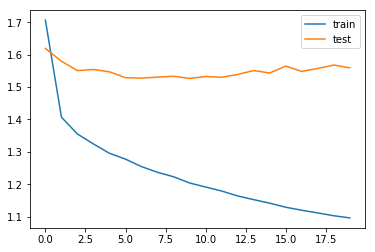

In [15]:
# fit network and plot loss
ltsm_history = lstm_model.fit(training_input_lstm, training_output_lstm,
                              epochs=epochs, batch_size=batch_size,
                              validation_data=(testing_input_lstm, testing_output_lstm),
                              verbose=1, shuffle=True, callbacks=[early_stop])

# plot history
plt.plot(ltsm_history.history['loss'], label='train')
plt.plot(ltsm_history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Network 3 - encoder-decoder LSTM

In [16]:
# need to reshape training/testing output to this form!
training_output_enc_dec_lstm = training_output_lstm.reshape(
    (training_output_lstm.shape[0], forecast_steps, training_output_lstm.shape[1]))
testing_output_enc_dec_lstm = testing_output_lstm.reshape(
    (testing_output_lstm.shape[0], forecast_steps, testing_output_lstm.shape[1]))

In [17]:
def build_enc_dec_lstm_model(LSTM_nodes = 200,
                             dense_nodes = 200,
                             LSTM_layers = 1,
                             dense_layers = 1,
                             activation = 'relu',
                             dropout = 0.2,
                             input_dim=training_input_lstm.shape[1:],
                             output_dim=training_output_lstm.shape[-1],
                             regress=False):
    """ build encoder-decoder LSTM model """
    model = keras.Sequential()

    ## encoder
    model.add(CuDNNLSTM(LSTM_nodes, input_shape=input_dim))
    model.add(Dropout(dropout))
    # internal representation of input sequence repeated multiple times,
    # once for each timestep in output sequence. this seq then presented to decoder
    model.add(RepeatVector(forecast_steps))

    ## decoder
    # outputs entire sequence, once for each forecasted timestep
    model.add(CuDNNLSTM(LSTM_nodes, return_sequences=True))
    model.add(Dropout(dropout))
    # dense layer interprets each timestep in the output sequence one at a time
    # to do this, use TimeDistributed wrapper
    model.add(TimeDistributed(Dense(dense_nodes, activation=activation)))
    model.add(Dropout(dropout))
    # output layer
    # network outputs 3d array with same dimensionality of samples, timesteps, features as input
    # connect to outputs if not using as part of a multi-input network
    if regress:
        model.add(TimeDistributed(Dense(output_dim)))

    return model

In [18]:
# design network
# network hyperparameters
LSTM_nodes = 200
dense_nodes = 200
LSTM_layers = 1
dense_layers = 1
activation = 'relu'
dropout = 0.3

# training parameters
epochs = 100
batch_size = 50
validation_split = 0.2

# build model
enc_dec_lstm_model = build_enc_dec_lstm_model(LSTM_nodes = LSTM_nodes,
                                              dense_nodes = dense_nodes,
                                              LSTM_layers = LSTM_layers,
                                              dense_layers = dense_layers,
                                              activation = activation,
                                              dropout = dropout,
                                              regress=True)

# define callback to force model to stop training if validation loss doesn't improve for 50 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
opt = keras.optimizers.Adam(lr=0.0005, decay=1e-6)
enc_dec_lstm_model.compile(loss='mean_squared_error', optimizer=opt)

Train on 12916 samples, validate on 3229 samples
Epoch 1/100
12916/12916 [==============================] - 2s 183us/step - loss: 1.7378 - val_loss: 1.6428
Epoch 2/100
12916/12916 [==============================] - 2s 148us/step - loss: 1.4459 - val_loss: 1.5903
Epoch 3/100
12916/12916 [==============================] - 2s 157us/step - loss: 1.3946 - val_loss: 1.5725
Epoch 4/100
12916/12916 [==============================] - 2s 165us/step - loss: 1.3693 - val_loss: 1.5586
Epoch 5/100
12916/12916 [==============================] - 2s 159us/step - loss: 1.3448 - val_loss: 1.5358
Epoch 6/100
12916/12916 [==============================] - 2s 137us/step - loss: 1.3278 - val_loss: 1.5450
Epoch 7/100
12916/12916 [==============================] - 2s 135us/step - loss: 1.3091 - val_loss: 1.5305
Epoch 8/100
12916/12916 [==============================] - 2s 166us/step - loss: 1.2939 - val_loss: 1.5328
Epoch 9/100
12916/12916 [==============================] - 2s 177us/step - loss: 1.2831 - val_l

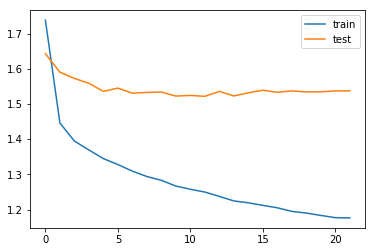

In [19]:
# fit network
enc_dec_ltsm_history = enc_dec_lstm_model.fit(training_input_lstm, training_output_enc_dec_lstm,
                              epochs=epochs, batch_size=batch_size,
                              validation_data=(testing_input_lstm, testing_output_enc_dec_lstm),
                              verbose=1, shuffle=True, callbacks=[early_stop]) # shuffle _sequences_, not steps

# plot history
plt.plot(enc_dec_ltsm_history.history['loss'], label='train')
plt.plot(enc_dec_ltsm_history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Network 4: dual-architecture LSTM+MLP

Here we want to set up the LSTM architecture on the time series data of previous bike flow vectors, and the MLP architecture on the hour/weekday/weather data, concatenating these into a single composite model

In [20]:
# get 3d input arrays for LSTM sequence training
reflection_steps = 3
forecast_steps = 1

# will use previous bike flow measurements as input sequence
sf = SequenceFrame(bike_flux_data,
                   forecast_vars=['delta_.*'],
                   reflection_vars=['delta_.*'], # can use prev vals of delta_.* alone or all vars .*
                   lookahead_vars=[],
                   forecast_steps=forecast_steps,
                   reflection_steps=reflection_steps)

# get appropriately shaped 3d input + 2d output arrays
input_vals_lstm_dual, output_vals_lstm_dual = sf.reshaped_LSTM_values()

In [21]:
# get 2d array of input vals for MLPO
# here, these are known variables at the single predicted timestep 
# use hour/weekday/weather data (weather should be known an hour in adv so should be fine)
input_vals_mlp_dual = sf.matching_vars_at_timestep("[^d].*", timestep=0).values
output_vals_mlp_dual = sf.matching_vars_at_timestep("delta_.*", timestep=0).values
# to generalise to future sequence, concat timesteps

In [22]:
# check both network inputs match up and input/output lengths consistent
assert len(input_vals_mlp_dual) == len(input_vals_lstm_dual)
assert len(output_vals_mlp_dual) == len(output_vals_lstm_dual)
assert len(input_vals_mlp_dual) == len(output_vals_mlp_dual)

In [23]:
# split data into 80% train+validate (keras will split validation), 20% test
# this time, the last 20% is immediately following the remaining 80% in time
imax_tr_dual = int(0.8*len(input_vals_lstm_dual))
imax_ts_dual = len(input_vals_lstm_dual)

In [24]:
# split into input and output for training and testing. 
# for lstm, input includes sequence of previous outputs
training_input_lstm_dual, training_output_lstm_dual = input_vals_lstm_dual[:imax_tr_dual], output_vals_lstm_dual[:imax_tr_dual]
testing_input_lstm_dual, testing_output_lstm_dual = input_vals_lstm_dual[imax_tr_dual:], output_vals_lstm_dual[imax_tr_dual:]

training_input_mlp_dual, training_output_mlp_dual = input_vals_mlp_dual[:imax_tr_dual], output_vals_mlp_dual[:imax_tr_dual]
testing_input_mlp_dual, testing_output_mlp_dual = input_vals_mlp_dual[imax_tr_dual:], output_vals_mlp_dual[imax_tr_dual:]

In [25]:
# get a random permutation with which to shuffle both inputs and outputs (so that they remain in correspondence)
trn_shuff_perm = np.random.permutation(training_input_lstm_dual.shape[0])
tst_shuff_perm = np.random.permutation(testing_input_lstm_dual.shape[0])

# shuffle
training_input_lstm_dual = training_input_lstm_dual[trn_shuff_perm]
training_output_lstm_dual = training_output_lstm_dual[trn_shuff_perm]
training_input_mlp_dual = training_input_mlp_dual[trn_shuff_perm]
training_output_mlp_dual = training_output_mlp_dual[trn_shuff_perm]

testing_input_lstm_dual = testing_input_lstm_dual[tst_shuff_perm]
testing_output_lstm_dual = testing_output_lstm_dual[tst_shuff_perm]
testing_input_mlp_dual = testing_input_mlp_dual[tst_shuff_perm]
testing_output_mlp_dual = testing_output_mlp_dual[tst_shuff_perm]

In [26]:
# check inputs for consistency
# these should be arrays of {reflection_steps} of bike flow vectors from prev timesteps
print("inputs (training): LSTM")
print(training_input_lstm_dual.shape)
print(training_input_lstm_dual[0])
# these should be one-hot day/hour labels + float weather readings
print("inputs (training): MLP")
print(training_input_mlp_dual.shape)
print(training_input_mlp_dual[0])

inputs (training): LSTM
(12923, 3, 70)
[[-3.  0.  0.  0.  2. -1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  2.  0. -1.  0. -2.  0.  0.  0.  0.  0.  0. -1.  3. -1.  1. -2.  1.
   3. -2.  4. -2. -2.  0.  1.  0.  0. -2. -2.  0.  1. -1.  1.  1.  0.  0.
  -6. -2. -1.  2.  0.  0.  2.  0. -1.  0. -2.  0.  0.  0. -6. -2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0. -3.  2.  0.  2. -1.  0.  0.  0.  1.  0. -1.  0.  0. -1.  0.  0. -1.
  -1.  0. -2.  1.  0.  4.  2.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.
  -1.  0. -1.  0.  0.  0.  2.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]
inputs (training): MLP
(12923, 166)
[ 0.          0.          0.          0.          1.     

In [27]:
# check for consistency
print("outputs (training):")
print(training_output_mlp_dual.shape)
print(training_output_lstm_dual.shape)
print("first elements:")
print(training_output_mlp_dual[0])
print(training_output_lstm_dual[0])
print("\noutputs (testing):")
print(testing_output_mlp_dual.shape)
print(testing_output_lstm_dual.shape)
print("first elements:")
print(testing_output_mlp_dual[0])
print(testing_output_lstm_dual[0])

outputs (training):
(12923, 70)
(12923, 70)
first elements:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]

outputs (testing):
(3231, 70)
(3231, 70)
first elements:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  1  1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  1  1]


In [40]:
# design network
# network hyperparameters
LSTM_nodes = 200
dense_nodes = 200
LSTM_layers = 1
dense_layers = 3
activation = 'relu'
dropout = 0.8

# training parameters
epochs = 100
batch_size = 50
validation_split = 0.2

opt = keras.optimizers.Adam(lr=1e-3, decay=1e-6)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [38]:
# try to load saved weights for MLP 
try:
    raise Exception
    mlp = keras.models.load_model('mlp_model.h5')
    mlp = keras.Model(mlp.inputs, mlp.layers[-2].output)
except:
    print("woops. making new mlp model...")
    mlp = build_mlp_model(regress=False,
                          activation=activation,
                          dropout=dropout,
                          nodes=dense_nodes,
                          layers=dense_layers,
                          input_dim=training_input_mlp_dual.shape[1],
                          output_dim=training_output_mlp_dual.shape[1])
else:
    print("loaded trained mlp model weights for MLP prong!")

# create the MLP and CNN models
lstm = build_lstm_model(regress=False,
                        activation=activation,
                        dropout=dropout,
                        LSTM_layers=LSTM_layers,
                        reflection_steps=reflection_steps,
                        input_dim=training_input_lstm_dual.shape[-1],
                        output_dim=training_output_lstm_dual.shape[1])
 
# create the input to our final set of layers as the *output* of both
# the MLP and LSTM
combinedInput = concatenate([mlp.output, lstm.output])
 
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(100, activation="relu")(combinedInput)
x = Dense(training_output_mlp_dual.shape[1], activation="linear")(x)
 
# our final model will accept categorical/numerical data on the MLP
# input and sequences on LSTM input
model = keras.Model(inputs=[mlp.input, lstm.input], outputs=x)

woops. making new mlp model...


In [41]:
model.compile(loss="mse", optimizer=opt)

In [42]:
# train the composite model
print("[INFO] training model...")
combined_history = model.fit(
                    [training_input_mlp_dual, training_input_lstm_dual], training_output_mlp_dual,
                    validation_data=([testing_input_mlp_dual, testing_input_lstm_dual], testing_output_mlp_dual),
                    shuffle=False,
                    epochs=epochs, batch_size=batch_size, callbacks=[early_stop])
 
    
# plot history
plt.plot(combined_history.history['loss'], label='train')
plt.plot(combined_history.history['val_loss'], label='test')
plt.legend()
plt.show()

[INFO] training model...
Train on 12923 samples, validate on 3231 samples
Epoch 1/100
12923/12923 [==============================] - 2s 176us/step - loss: 2.1503 - val_loss: 1.8566
Epoch 2/100
12923/12923 [==============================] - 2s 126us/step - loss: 1.6702 - val_loss: 1.7503
Epoch 3/100
12923/12923 [==============================] - 2s 126us/step - loss: 1.6189 - val_loss: 1.7751
Epoch 4/100
12923/12923 [==============================] - 2s 137us/step - loss: 1.5696 - val_loss: 1.7536
Epoch 5/100
12923/12923 [==============================] - 2s 158us/step - loss: 1.5392 - val_loss: 1.6832
Epoch 6/100
12923/12923 [==============================] - 2s 133us/step - loss: 1.5211 - val_loss: 1.6833
Epoch 7/100
12923/12923 [==============================] - 2s 138us/step - loss: 1.5071 - val_loss: 1.6742
Epoch 8/100
12923/12923 [==============================] - 2s 131us/step - loss: 1.4910 - val_loss: 1.6720
Epoch 9/100
12923/12923 [==============================] - 2s 139us/st

KeyboardInterrupt: 